In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [2]:
import tensorflow

In [3]:
import matplotlib

matplotlib.use('Agg')
import numpy as np

from tqdm import tqdm
from keras.optimizers import Adam
from keras.models import Sequential
import math
from PIL import Image

Using TensorFlow backend.


In [4]:
from keras import backend as K

In [5]:
config = K.tf.ConfigProto(intra_op_parallelism_threads=4, inter_op_parallelism_threads=4)
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.8
K.set_session(K.tf.Session(config=config))

In [6]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6356534334495634621, name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 15341255367561624187
 physical_device_desc: "device: XLA_GPU device", name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 4489734876816841398
 physical_device_desc: "device: XLA_CPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9377205452
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3754604118251300566
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:0a:00.0, compute capability: 6.1"]

In [7]:
from dcgan import DCGAN
from utils import TextImage2013, draw_text, prepare_conditions

In [8]:
BATCH_SIZE = 32
EPOCHS = 10
RANDOM_SIZE = 100
imgdim = (256, 256, 3)

In [9]:
def save_imagegrid(imagearray, img_name, batch_size):
    width = imagearray.shape[2]
    height = imagearray.shape[1]
    mode = 'RGB'
    num_elements = int(math.sqrt(batch_size))
    imagegrid = Image.new(mode, (width * num_elements, height * num_elements))
    for j in range(num_elements * num_elements):
        randimg = imagearray[j] * 127.5 + 127.5
        img = Image.fromarray(randimg.astype('uint8'), mode=mode)
        imagegrid.paste(im=img, box=((j % num_elements) * width, height * (j // num_elements)))
    filename = str(img_name) + '.png'
    imagegrid.save(filename)
    print("grid saved " + filename)

In [10]:
training = TextImage2013()
text_labels = []

img_80.jpg 1
img_154.jpg 2
img_84.jpg 3
img_134.jpg 4
img_26.jpg 5
img_17.jpg 6
img_32.jpg 7
img_220.jpg 8
img_87.jpg 9
img_79.jpg 10
img_199.jpg 11
img_44.jpg 12
img_204.jpg 13
img_43.jpg 14
img_207.jpg 15
img_193.jpg 16
img_114.jpg 17
img_59.jpg 18
img_53.jpg 19
img_117.jpg 20
img_123.jpg 21
img_94.jpg 22
img_28.jpg 23
img_188.jpg 24
img_163.jpg 25
img_209.jpg 26
img_106.jpg 27
img_191.jpg 28
img_172.jpg 29
img_167.jpg 30
img_218.jpg 31
img_10.jpg 32
img_164.jpg 33
img_176.jpg 34
img_227.jpg 35
img_122.jpg 36
img_183.jpg 37
img_112.jpg 38
img_47.jpg 39
img_105.jpg 40
img_100.jpg 41
img_195.jpg 42
img_110.jpg 43
img_30.jpg 44
img_71.jpg 45
img_74.jpg 46
img_73.jpg 47
img_64.jpg 48
img_40.jpg 49
img_198.jpg 50
img_8.jpg 51
img_85.jpg 52
img_82.jpg 53
img_184.jpg 54
img_24.jpg 55
img_86.jpg 56
img_27.jpg 57
img_91.jpg 58
img_2.jpg 59
img_109.jpg 60
img_29.jpg 61
img_182.jpg 62
img_35.jpg 63
img_102.jpg 64
img_118.jpg 65
img_146.jpg 66
img_68.jpg 67
img_77.jpg 68
img_135.jpg 69
img_185.j

In [11]:
from keras.losses import binary_crossentropy

In [12]:
def loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred)
    #rec_loss = rec_model.predict_on_batch(y_pred)
    return loss # + rec_loss

In [13]:
from keras.datasets import cifar10

In [14]:
ytrain = training.get_labels()

In [15]:
Ganmodel = DCGAN(img_dims=imgdim)
generator = Ganmodel.generator256()
generator.summary()
gen_sgd = Adam(lr=0.0002, beta_1=0.5)
generator.compile(loss={"add_text": 'binary_crossentropy', "relur": loss}, optimizer='sgd') # losses for each output

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_0 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 100)          400         input_0[0][0]                    
__________________________________________________________________________________________________
fc1 (Dense)                     (None, 1048576)      105906176   bn1[0][0]                        
__________________________________________________________________________________________________
bn2 (BatchNormalization)        (None, 1048576)      4194304     fc1[0][0]                        
_____________________________________

/nfs/home/vefimova/diplom/TextPlacement/TextPlacement/cdcgan/dcgan.py:176: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`
  model = Model(input=[inputs, input_c], output=[l11, r2]) #l15)


In [16]:
discriminator = Ganmodel.discriminator256()
discriminator.summary()
discriminator_sgd = Adam(lr=0.0002, beta_1=0.5)
discriminator.compile(loss='binary_crossentropy', optimizer=discriminator_sgd)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_d (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 252, 252, 64)      4864      
_________________________________________________________________
relu1 (LeakyReLU)            (None, 252, 252, 64)      0         
_________________________________________________________________
pool1 (AveragePooling2D)     (None, 126, 126, 64)      0         
_________________________________________________________________
conv2 (Conv2D)               (None, 122, 122, 128)     204928    
_________________________________________________________________
bn1 (BatchNormalization)     (None, 122, 122, 128)     512       
_________________________________________________________________
relu2 (LeakyReLU)            (None, 122, 122, 128)     0         
__________

/nfs/home/vefimova/diplom/TextPlacement/TextPlacement/cdcgan/dcgan.py:210: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("si..., inputs=Tensor("in...)`
  model = Model(input=inputs, output=l13)


In [17]:
gan = Ganmodel.generator_containing_discriminator(generator, discriminator)
gan.compile(loss={"model_1": 'binary_crossentropy',
                  "model_2": 'binary_crossentropy'}, optimizer=gen_sgd)

In [18]:
# Model Training

iteration = 0

nb_of_iterations_per_epoch = int(training.num_samples / BATCH_SIZE)
print("Number of iterations per epoch: {0}".format(nb_of_iterations_per_epoch))
losses = {"generator": [], "discriminator": []}


Number of iterations per epoch: 7


In [19]:
for epoch in range(EPOCHS):
    pbar = tqdm(desc="Epoch: {0}".format(epoch), total=imgdim[0])

    for i in range(nb_of_iterations_per_epoch):
        random_array = np.random.uniform(-1, 1, (BATCH_SIZE, RANDOM_SIZE)) #(128, 100)

        text_labels, conditions = prepare_conditions(BATCH_SIZE, imgdim)

        generator.fit([random_array, conditions], {"add_text": np.ones((BATCH_SIZE, imgdim[0], imgdim[1], imgdim[2])), # labels for each output
                                                     "relur": np.ones((BATCH_SIZE, 128))}) #, callbacks = [history])

        generated_images, texts_pred = generator.predict_on_batch([random_array, conditions])

        if ((i % 10) == 0):
            save_imagegrid(generated_images, '../images/generated_per_epoch/e{:02d}b{:03d}'.format(epoch, i), BATCH_SIZE)

        if (i % 2 == 0):
            start = (i // 2 * BATCH_SIZE)
            end = (((i // 2) + 1) * BATCH_SIZE)
            images = training.image_generator(BATCH_SIZE)
            labels = [1] * (BATCH_SIZE)
        else:
            images = generated_images
            labels = [0] * (BATCH_SIZE)

        discriminator_loss = discriminator.train_on_batch(images, labels)
        losses["discriminator"].append(discriminator_loss)

        random_array = np.random.uniform(-1, 1, (BATCH_SIZE, RANDOM_SIZE))
        text_labels, conditions = prepare_conditions(BATCH_SIZE, imgdim)

        labels = [1] * (BATCH_SIZE)
        discriminator.trainable = False
        generator_loss = gan.train_on_batch([random_array, conditions], 
                                            {"model_2": np.array(labels),
                                            "model_1": np.ones((BATCH_SIZE, 128))})
        discriminator.trainable = True
        losses["generator"].append(generator_loss)

        pbar.update(BATCH_SIZE)

        iteration += 1

        discriminator.save_weights('../models/discriminator_cifar.h5')
        generator.save_weights('../models/generator_cifar.h5')

pbar.close()

Epoch: 0:   0%|          | 0/256 [00:00<?, ?it/s]

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
32/32 [==============================] - 9s 281ms/step - loss: 21.0139 - add_text_loss: 12.3908 - relur_loss: 8.6232
grid saved ../images/generated_per_epoch/e00b000.png


/nfs/home/vefimova/diplom/tenv/lib/python3.5/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
Epoch: 0:  12%|█▎        | 32/256 [00:27<03:10,  1.18it/s]

Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 8.7612 - add_text_loss: 4.9103e-05 - relur_loss: 8.7612


Epoch: 0:  25%|██▌       | 64/256 [00:41<02:19,  1.38it/s]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.8352 - add_text_loss: 4.9162e-05 - relur_loss: 8.8351


Epoch: 0:  38%|███▊      | 96/256 [00:54<01:40,  1.59it/s]

Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 8.8867 - add_text_loss: 4.9232e-05 - relur_loss: 8.8867


Epoch: 0:  50%|█████     | 128/256 [01:05<01:10,  1.82it/s]

Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 8.7470 - add_text_loss: 4.9236e-05 - relur_loss: 8.7470


Epoch: 0:  62%|██████▎   | 160/256 [01:18<00:48,  2.00it/s]

Epoch 1/1
32/32 [==============================] - 0s 4ms/step - loss: 8.7725 - add_text_loss: 4.9278e-05 - relur_loss: 8.7725


Epoch: 0:  75%|███████▌  | 192/256 [01:28<00:28,  2.21it/s]

Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 8.6219 - add_text_loss: 4.9156e-05 - relur_loss: 8.6218


Epoch: 1:   0%|          | 0/256 [00:00<?, ?it/s]

Epoch 1/1
32/32 [==============================] - 0s 7ms/step - loss: 8.6105 - add_text_loss: 4.9202e-05 - relur_loss: 8.6105
grid saved ../images/generated_per_epoch/e01b000.png



Epoch: 1:  12%|█▎        | 32/256 [00:03<00:24,  9.21it/s]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.7497 - add_text_loss: 4.9256e-05 - relur_loss: 8.7497



Epoch: 1:  25%|██▌       | 64/256 [00:12<00:31,  6.08it/s]

Epoch 1/1
32/32 [==============================] - 0s 9ms/step - loss: 8.4619 - add_text_loss: 4.9066e-05 - relur_loss: 8.4619



Epoch: 1:  38%|███▊      | 96/256 [00:23<00:34,  4.57it/s]

Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 8.5390 - add_text_loss: 4.9155e-05 - relur_loss: 8.5389



Epoch: 1:  50%|█████     | 128/256 [00:33<00:31,  4.08it/s]

Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 8.5963 - add_text_loss: 4.9073e-05 - relur_loss: 8.5962



Epoch: 1:  62%|██████▎   | 160/256 [00:45<00:27,  3.50it/s]

Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 8.5774 - add_text_loss: 4.9199e-05 - relur_loss: 8.5773



Epoch: 1:  75%|███████▌  | 192/256 [00:56<00:18,  3.39it/s]

Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 8.5785 - add_text_loss: 4.9309e-05 - relur_loss: 8.5785



Epoch: 1:  88%|████████▊ | 224/256 [01:07<00:09,  3.22it/s]

Epoch: 2:   0%|          | 0/256 [00:00<?, ?it/s]

Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 8.3391 - add_text_loss: 4.9308e-05 - relur_loss: 8.3390
grid saved ../images/generated_per_epoch/e02b000.png




Epoch: 2:  12%|█▎        | 32/256 [00:02<00:17, 12.70it/s]

Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 8.4728 - add_text_loss: 4.9206e-05 - relur_loss: 8.4728




Epoch: 2:  25%|██▌       | 64/256 [00:10<00:25,  7.46it/s]

Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 8.5488 - add_text_loss: 4.9301e-05 - relur_loss: 8.5488




Epoch: 2:  38%|███▊      | 96/256 [00:23<00:33,  4.75it/s]

Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 8.5230 - add_text_loss: 4.9278e-05 - relur_loss: 8.5229




Epoch: 2:  50%|█████     | 128/256 [00:33<00:30,  4.16it/s]

Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 8.6872 - add_text_loss: 4.9072e-05 - relur_loss: 8.6871




Epoch: 2:  62%|██████▎   | 160/256 [00:48<00:29,  3.25it/s]

Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 8.7960 - add_text_loss: 4.9237e-05 - relur_loss: 8.7960




Epoch: 2:  75%|███████▌  | 192/256 [00:58<00:19,  3.24it/s]

Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 8.5426 - add_text_loss: 4.9174e-05 - relur_loss: 8.5425




Epoch: 2:  88%|████████▊ | 224/256 [01:09<00:10,  3.11it/s]


Epoch: 3:   0%|          | 0/256 [00:00<?, ?it/s]

Epoch 1/1
32/32 [==============================] - 0s 4ms/step - loss: 8.4174 - add_text_loss: 4.9197e-05 - relur_loss: 8.4174
grid saved ../images/generated_per_epoch/e03b000.png





Epoch: 3:  12%|█▎        | 32/256 [00:02<00:14, 15.16it/s]

Epoch 1/1
32/32 [==============================] - 0s 4ms/step - loss: 8.3449 - add_text_loss: 4.9038e-05 - relur_loss: 8.3448





Epoch: 3:  25%|██▌       | 64/256 [00:11<00:26,  7.22it/s]

Epoch 1/1
32/32 [==============================] - 0s 4ms/step - loss: 8.4595 - add_text_loss: 4.9331e-05 - relur_loss: 8.4595





Epoch: 3:  38%|███▊      | 96/256 [00:24<00:34,  4.70it/s]

Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 8.6402 - add_text_loss: 4.9208e-05 - relur_loss: 8.6402





Epoch: 3:  50%|█████     | 128/256 [00:33<00:30,  4.18it/s]

Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 8.4169 - add_text_loss: 4.9285e-05 - relur_loss: 8.4168





Epoch: 3:  62%|██████▎   | 160/256 [00:46<00:27,  3.46it/s]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.5589 - add_text_loss: 4.9161e-05 - relur_loss: 8.5588





Epoch: 3:  75%|███████▌  | 192/256 [00:56<00:18,  3.37it/s]

Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 8.4904 - add_text_loss: 4.9151e-05 - relur_loss: 8.4903





Epoch: 3:  88%|████████▊ | 224/256 [01:08<00:10,  3.13it/s]



Epoch: 4:   0%|          | 0/256 [00:00<?, ?it/s]

Epoch 1/1
32/32 [==============================] - 0s 7ms/step - loss: 8.4506 - add_text_loss: 4.9213e-05 - relur_loss: 8.4506
grid saved ../images/generated_per_epoch/e04b000.png






Epoch: 4:  12%|█▎        | 32/256 [00:02<00:20, 11.09it/s]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.4603 - add_text_loss: 4.9046e-05 - relur_loss: 8.4603






Epoch: 4:  25%|██▌       | 64/256 [00:14<00:32,  5.86it/s]

Epoch 1/1
32/32 [==============================] - 0s 4ms/step - loss: 8.2628 - add_text_loss: 4.9097e-05 - relur_loss: 8.2627






Epoch: 4:  38%|███▊      | 96/256 [00:27<00:39,  4.08it/s]

Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 8.3650 - add_text_loss: 4.9224e-05 - relur_loss: 8.3650






Epoch: 4:  50%|█████     | 128/256 [00:41<00:38,  3.34it/s]

Epoch 1/1
32/32 [==============================] - 0s 7ms/step - loss: 8.2106 - add_text_loss: 4.9295e-05 - relur_loss: 8.2105






Epoch: 4:  62%|██████▎   | 160/256 [00:52<00:30,  3.19it/s]

Epoch 1/1
32/32 [==============================] - 0s 4ms/step - loss: 8.4780 - add_text_loss: 4.9098e-05 - relur_loss: 8.4779






Epoch: 4:  75%|███████▌  | 192/256 [01:02<00:19,  3.23it/s]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.3036 - add_text_loss: 4.9067e-05 - relur_loss: 8.3036






Epoch: 4:  88%|████████▊ | 224/256 [01:13<00:10,  3.07it/s]




Epoch: 5:   0%|          | 0/256 [00:00<?, ?it/s]

Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 8.2094 - add_text_loss: 4.9060e-05 - relur_loss: 8.2093
grid saved ../images/generated_per_epoch/e05b000.png







Epoch: 5:  12%|█▎        | 32/256 [00:02<00:18, 11.80it/s]

Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 8.2086 - add_text_loss: 4.9188e-05 - relur_loss: 8.2086







Epoch: 5:  25%|██▌       | 64/256 [00:12<00:29,  6.50it/s]

Epoch 1/1
32/32 [==============================] - 0s 4ms/step - loss: 8.5227 - add_text_loss: 4.8943e-05 - relur_loss: 8.5227







Epoch: 5:  38%|███▊      | 96/256 [00:24<00:34,  4.64it/s]

Epoch 1/1
32/32 [==============================] - 1s 16ms/step - loss: 8.2134 - add_text_loss: 4.9101e-05 - relur_loss: 8.2133







Epoch: 5:  50%|█████     | 128/256 [00:34<00:31,  4.04it/s]

Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 7.9950 - add_text_loss: 4.9135e-05 - relur_loss: 7.9950







Epoch: 5:  62%|██████▎   | 160/256 [00:48<00:28,  3.32it/s]

Epoch 1/1
32/32 [==============================] - 0s 4ms/step - loss: 8.3128 - add_text_loss: 4.9304e-05 - relur_loss: 8.3128







Epoch: 5:  75%|███████▌  | 192/256 [00:58<00:19,  3.23it/s]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.4249 - add_text_loss: 4.9249e-05 - relur_loss: 8.4248







Epoch: 5:  88%|████████▊ | 224/256 [01:11<00:10,  3.00it/s]





Epoch: 6:   0%|          | 0/256 [00:00<?, ?it/s]

Epoch 1/1
32/32 [==============================] - 0s 8ms/step - loss: 8.2822 - add_text_loss: 4.9113e-05 - relur_loss: 8.2822
grid saved ../images/generated_per_epoch/e06b000.png








Epoch: 6:  12%|█▎        | 32/256 [00:03<00:27,  8.04it/s]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.2673 - add_text_loss: 4.9103e-05 - relur_loss: 8.2673








Epoch: 6:  25%|██▌       | 64/256 [00:13<00:33,  5.80it/s]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.2174 - add_text_loss: 4.9179e-05 - relur_loss: 8.2173








Epoch: 6:  38%|███▊      | 96/256 [00:24<00:36,  4.36it/s]

Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 8.3153 - add_text_loss: 4.9054e-05 - relur_loss: 8.3153








Epoch: 6:  50%|█████     | 128/256 [00:34<00:32,  3.98it/s]

Epoch 1/1
32/32 [==============================] - 0s 4ms/step - loss: 8.3050 - add_text_loss: 4.9132e-05 - relur_loss: 8.3049








Epoch: 6:  62%|██████▎   | 160/256 [00:47<00:28,  3.37it/s]

Epoch 1/1
32/32 [==============================] - 0s 4ms/step - loss: 8.3717 - add_text_loss: 4.9143e-05 - relur_loss: 8.3716








Epoch: 6:  75%|███████▌  | 192/256 [00:57<00:19,  3.30it/s]

Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 8.1889 - add_text_loss: 4.9117e-05 - relur_loss: 8.1888








Epoch: 6:  88%|████████▊ | 224/256 [01:08<00:10,  3.13it/s]






Epoch: 7:   0%|          | 0/256 [00:00<?, ?it/s]

Epoch 1/1
32/32 [==============================] - 0s 4ms/step - loss: 8.3749 - add_text_loss: 4.9183e-05 - relur_loss: 8.3748
grid saved ../images/generated_per_epoch/e07b000.png









Epoch: 7:  12%|█▎        | 32/256 [00:02<00:15, 14.26it/s]

Epoch 1/1
32/32 [==============================] - 0s 4ms/step - loss: 8.2530 - add_text_loss: 4.9050e-05 - relur_loss: 8.2529









Epoch: 7:  25%|██▌       | 64/256 [00:12<00:27,  7.00it/s]

Epoch 1/1
32/32 [==============================] - 0s 4ms/step - loss: 8.2201 - add_text_loss: 4.9120e-05 - relur_loss: 8.2201









Epoch: 7:  38%|███▊      | 96/256 [00:24<00:33,  4.71it/s]

Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 8.1902 - add_text_loss: 4.9070e-05 - relur_loss: 8.1901









Epoch: 7:  50%|█████     | 128/256 [00:32<00:29,  4.36it/s]

Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 8.1716 - add_text_loss: 4.9135e-05 - relur_loss: 8.1716









Epoch: 7:  62%|██████▎   | 160/256 [00:44<00:26,  3.69it/s]

Epoch 1/1
32/32 [==============================] - 0s 7ms/step - loss: 8.2469 - add_text_loss: 4.9204e-05 - relur_loss: 8.2468









Epoch: 7:  75%|███████▌  | 192/256 [00:55<00:18,  3.48it/s]

Epoch 1/1
32/32 [==============================] - 0s 4ms/step - loss: 8.2394 - add_text_loss: 4.9179e-05 - relur_loss: 8.2394









Epoch: 7:  88%|████████▊ | 224/256 [01:05<00:09,  3.29it/s]







Epoch: 8:   0%|          | 0/256 [00:00<?, ?it/s]

Epoch 1/1
32/32 [==============================] - 0s 4ms/step - loss: 8.1393 - add_text_loss: 4.9126e-05 - relur_loss: 8.1392
grid saved ../images/generated_per_epoch/e08b000.png










Epoch: 8:  12%|█▎        | 32/256 [00:03<00:21, 10.50it/s]

Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 8.2966 - add_text_loss: 4.9166e-05 - relur_loss: 8.2965










Epoch: 8:  25%|██▌       | 64/256 [00:14<00:32,  5.85it/s]

Epoch 1/1
32/32 [==============================] - 0s 7ms/step - loss: 8.0351 - add_text_loss: 4.9104e-05 - relur_loss: 8.0350










Epoch: 8:  38%|███▊      | 96/256 [00:26<00:37,  4.22it/s]

Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 8.1201 - add_text_loss: 4.9147e-05 - relur_loss: 8.1200










Epoch: 8:  50%|█████     | 128/256 [00:35<00:32,  3.98it/s]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.1697 - add_text_loss: 4.9229e-05 - relur_loss: 8.1697










Epoch: 8:  62%|██████▎   | 160/256 [00:49<00:29,  3.25it/s]

Epoch 1/1
32/32 [==============================] - 0s 4ms/step - loss: 8.0007 - add_text_loss: 4.9277e-05 - relur_loss: 8.0006










Epoch: 8:  75%|███████▌  | 192/256 [00:58<00:18,  3.37it/s]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.1431 - add_text_loss: 4.8970e-05 - relur_loss: 8.1431










Epoch: 8:  88%|████████▊ | 224/256 [01:10<00:10,  3.16it/s]








Epoch: 9:   0%|          | 0/256 [00:00<?, ?it/s]

Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 8.3041 - add_text_loss: 4.9151e-05 - relur_loss: 8.3041
grid saved ../images/generated_per_epoch/e09b000.png











Epoch: 9:  12%|█▎        | 32/256 [00:03<00:21, 10.24it/s]

Epoch 1/1
32/32 [==============================] - 0s 4ms/step - loss: 8.3064 - add_text_loss: 4.9046e-05 - relur_loss: 8.3063











Epoch: 9:  25%|██▌       | 64/256 [00:13<00:31,  6.11it/s]

Epoch 1/1
32/32 [==============================] - 0s 7ms/step - loss: 8.0648 - add_text_loss: 4.9134e-05 - relur_loss: 8.0648











Epoch: 9:  38%|███▊      | 96/256 [00:22<00:32,  4.94it/s]

Epoch 1/1
32/32 [==============================] - 0s 7ms/step - loss: 8.1056 - add_text_loss: 4.9105e-05 - relur_loss: 8.1055











Epoch: 9:  50%|█████     | 128/256 [00:32<00:30,  4.21it/s]

Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 8.0267 - add_text_loss: 4.9131e-05 - relur_loss: 8.0267











Epoch: 9:  62%|██████▎   | 160/256 [00:44<00:26,  3.61it/s]

Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 8.1700 - add_text_loss: 4.9048e-05 - relur_loss: 8.1699











Epoch: 9:  75%|███████▌  | 192/256 [00:55<00:19,  3.36it/s]

Epoch 1/1
32/32 [==============================] - 0s 7ms/step - loss: 8.1260 - add_text_loss: 4.9051e-05 - relur_loss: 8.1260











Epoch: 9:  88%|████████▊ | 224/256 [01:07<00:10,  3.10it/s]

In [20]:
from IPython.display import Image

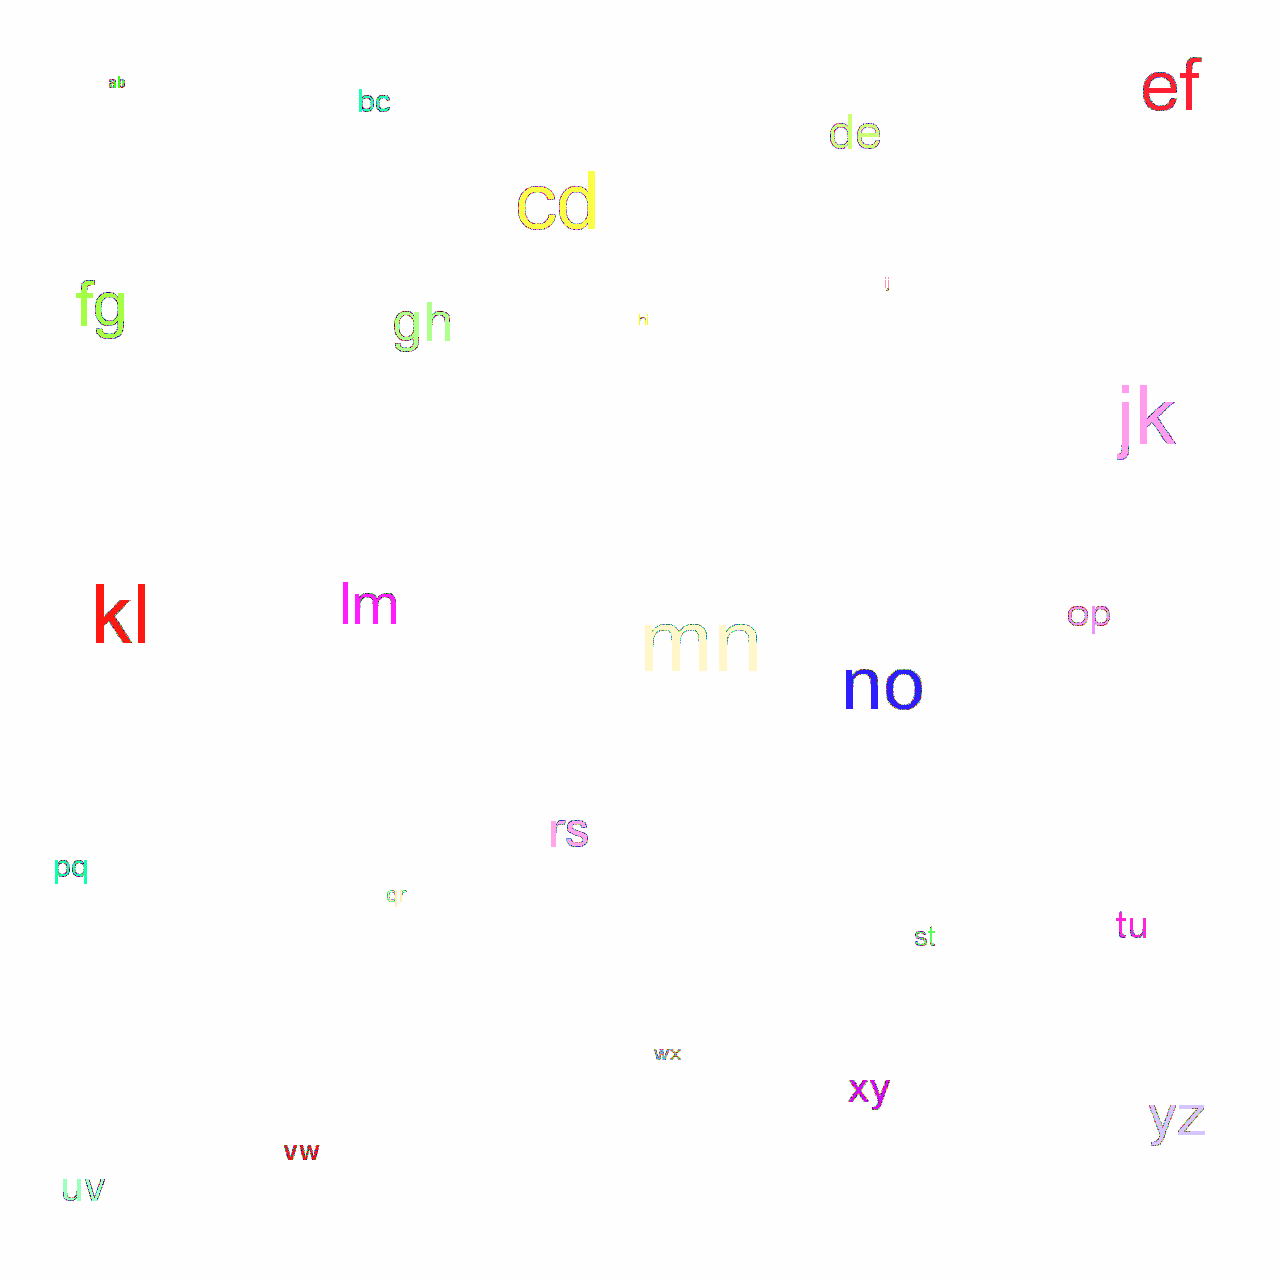

In [29]:
Image(filename='../images/generated_per_epoch/e00b000.png') 

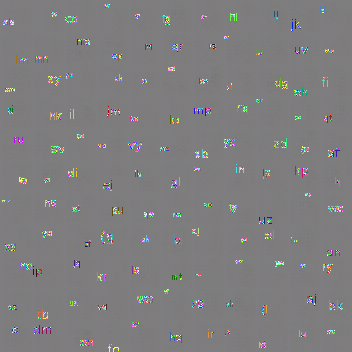

In [22]:
Image(filename='../images/generated_per_epoch/e00b100.png') 

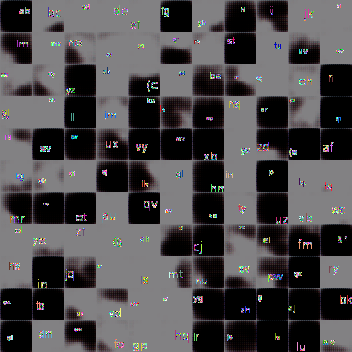

In [23]:
Image(filename='../images/generated_per_epoch/e00b200.png') 

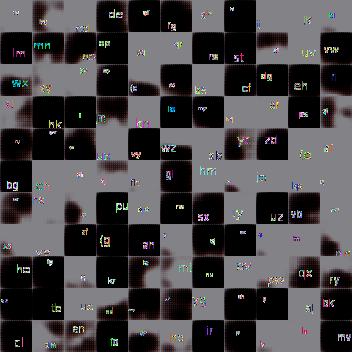

In [24]:
Image(filename='../images/generated_per_epoch/e00b300.png') 

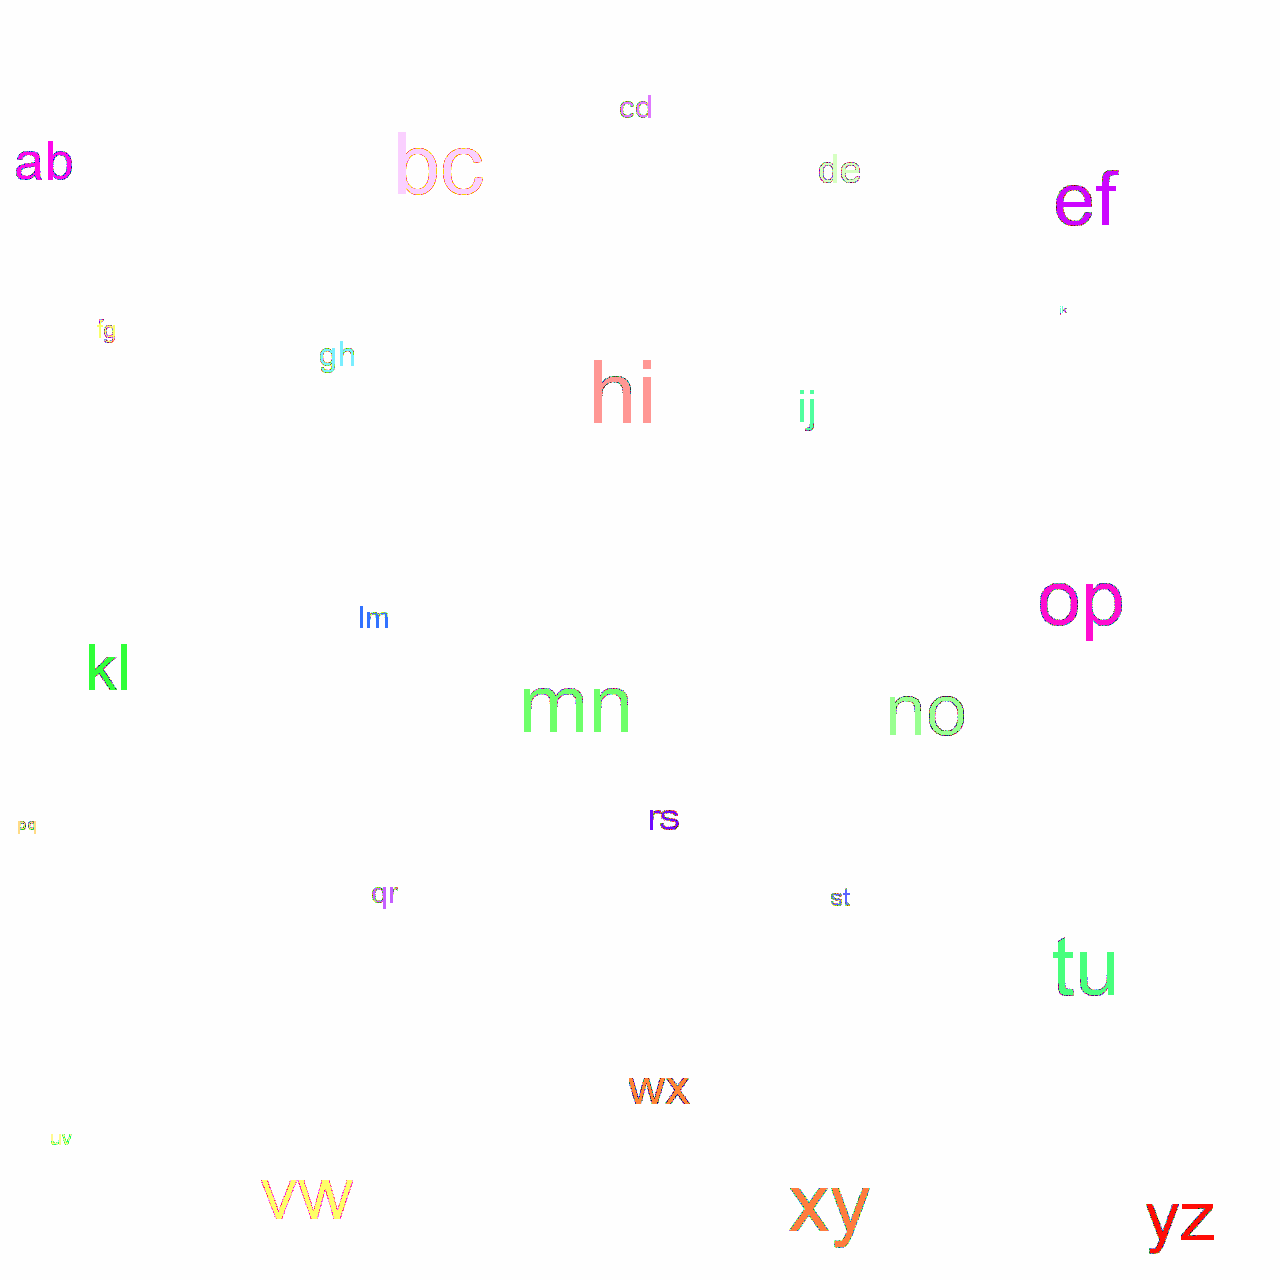

In [25]:
Image(filename='../images/generated_per_epoch/e01b000.png') 

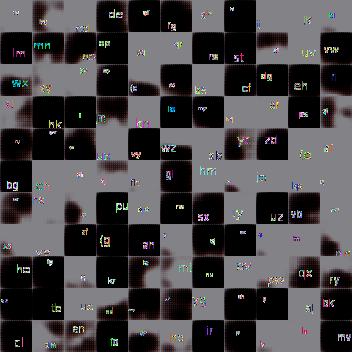

In [26]:
Image(filename='../images/generated_per_epoch/e00b300.png') 

In [27]:
os.getcwd()

'/nfs/home/vefimova/diplom/TextPlacement/TextPlacement/cdcgan'